

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!sudo sysctl vm.drop_caches=3

vm.drop_caches = 3


In [2]:
!pip install  imblearn

In [3]:
!pip install catboost

In [4]:
!pip install xgboost

In [5]:
import pandas as pd
import numpy as np
import math
import json
#% matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
#import pandasql
import seaborn as sns
from matplotlib import pyplot as plt
import preprocess as pp

In [6]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Clean up ~ Exploration ~ Engineering

### Profile

In [7]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['yr_w_starbucks']= profile['became_member_on'].apply(pp.age_calc)
profile.head()

,gender,age,id,became_member_on,income,yr_w_starbucks
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,3


customers who have unknown income are given default ages and personal details. I presume these customers never really gave their details and were assigned a unique ID by starbucks.Customers will be kept or dropped depending on their behaviour with the events data

In [9]:
profile[profile['income'].isnull()].describe()

,age,income,yr_w_starbucks
count,2175.0,0.0,2175.000000
mean,118.0,NaN,3.571954
std,0.0,NaN,1.012909
min,118.0,NaN,2.000000
25%,118.0,NaN,3.000000
50%,118.0,NaN,3.000000
75%,118.0,NaN,4.000000
max,118.0,NaN,7.000000


In [10]:
null_income=profile[profile['income'].isnull()]
null_income.merge(transcript, left_on='id', right_on='person')

,gender,age,id,became_member_on,income,yr_w_starbucks,person,event,value,time
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4,68be06ca386d4c31939f3a4f0e3dd783,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,4,68be06ca386d4c31939f3a4f0e3dd783,transaction,{'amount': 0.35000000000000003},360
...,...,...,...,...,...,...,...,...,...,...
33767,None,118,c02b10e8752c4d8e9b73f918558531f7,2015-12-11,NaN,5,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 1.3900000000000001},420
33768,None,118,c02b10e8752c4d8e9b73f918558531f7,2015-12-11,NaN,5,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 1.27},444
33769,None,118,c02b10e8752c4d8e9b73f918558531f7,2015-12-11,NaN,5,c02b10e8752c4d8e9b73f918558531f7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},504
33770,None,118,c02b10e8752c4d8e9b73f918558531f7,2015-12-11,NaN,5,c02b10e8752c4d8e9b73f918558531f7,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},516


In [11]:
null_income=None

These customers with no income have transactions so they will be left in the data set. But their null values will be replaced with `unknown U` for gender and mean for Income

In [12]:
#Replacing unknown income with the mean income
profile['income'] = profile['income'].fillna(profile['income'].mean())
#Replacing unknown genders with U for Unknown
profile['gender'] = profile['gender'].fillna('U')
#replacing outlier ages with the mean age
profile.age[profile['age']>100]=profile.age[profile['age']<=100].mean()
profile.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gender,age,id,became_member_on,income,yr_w_starbucks
0,U,54.3778,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,4
1,F,55.0000,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,3
2,U,54.3778,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,2
3,F,75.0000,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,3
4,U,54.3778,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,3


In [13]:
#Creating OHE for year of membership and gender
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))
member_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')
gender_dummies=profile['gender'].str.get_dummies().add_prefix('gender_')
profile = pd.concat([profile,gender_dummies, member_dummies], axis=1)
profile.drop(['year_joined','became_member_on'], axis=1, inplace=True)
profile.head()

,gender,age,id,income,yr_w_starbucks,gender_F,gender_M,gender_O,gender_U,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,U,54.3778,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,4,0,0,0,1,0,0,0,0,1,0
1,F,55.0000,0610b486422d4921ae7d2bf64640c50b,112000.000000,3,1,0,0,0,0,0,0,0,1,0
2,U,54.3778,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2,0,0,0,1,0,0,0,0,0,1
3,F,75.0000,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,3,1,0,0,0,0,0,0,0,1,0
4,U,54.3778,a03223e636434f42ac4c3df47e8bac43,65404.991568,3,0,0,0,1,0,0,0,0,1,0


### Transcript

In [14]:
transcript.rename(columns={'person':'id'}, inplace=True)
print(transcript.shape)
transcript.head()

(306534, 4)


,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
#breaking down into transactions and non-transactions
transaction =transcript[transcript['event']=='transaction']
transaction['amount'] = transaction['value'].apply(lambda x: list(x.values())[0])

offer=transcript[transcript['event']!='transaction']
offer['offer_id'] = offer['value'].apply(lambda x: list(x.values())[0])
offer.event.value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [16]:
offer_ohe=offer['event'].str.get_dummies()
offer=pd.concat([offer, offer_ohe], axis=1)
offer.drop(['value'], axis=1, inplace=True)
offer.head()

,id,event,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


Customers can complete the offer and not have viewed the offer. The correlation between offer completion and viewing shows

In [17]:
offer.corr()

,time,offer completed,offer received,offer viewed
time,1.000000,0.119338,-0.097710,0.001872
offer completed,0.119338,1.000000,-0.457541,-0.362868
offer received,-0.097710,-0.457541,1.000000,-0.662555
offer viewed,0.001872,-0.362868,-0.662555,1.000000


In [18]:
offer=offer.sort_values(by=['id','offer_id'])
offer.reset_index(inplace=True)
offer.rename(columns={'offer received':'offer_received','offer viewed': 'offer_viewed', 'offer completed': 'offer_completed'}, inplace=True)
offer.head()

,index,id,event,time,offer_id,offer_completed,offer_received,offer_viewed
0,247879,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,0,1,0
1,258884,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0,1,0
3,139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0,0,1
4,55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0


A customer can recieve the offer multiple times.SO we can pick the first time the offer was received and first view. Also to aggregate per customer and offer.

In [19]:
offer['time'] = offer['time'] + 0.5
offer['time_received'] = offer['offer_received'] * offer['time']
offer['time_viewed'] = offer['offer_viewed'] * offer['time']
offer['time_completed'] = offer['offer_completed'] * offer['time']

first_offers = offer.groupby(['id', 'offer_id', 'event']).min()
total_offers = offer.groupby(['id', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

first_offers.update(total_offers)

new_offer = first_offers.groupby(['id', 'offer_id']).max().reset_index()

new_offer.fillna(0, inplace=True)
new_offer.drop(['index'],axis=1, inplace=True)
new_offer.head()

,id,offer_id,time,offer_completed,offer_received,offer_viewed,time_received,time_viewed,time_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,504.5,540.5,528.5


### Portfolio

In [20]:
print(portfolio.shape)
portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [21]:
#OHE for the channels
mlb = MultiLabelBinarizer()
channel_ohe = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

offer_type_ohe = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_ohe, offer_type_ohe], axis=1)
portfolio.rename(columns={'id':'offer_id'},  inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [22]:
#Merging files
df2= new_offer.merge(portfolio, how='left', left_on='offer_id', right_on='offer_id')
df2.drop(['channels'],axis=1, inplace=True)
print(df2.shape)
df2.head().T

(63288, 20)


,0,1,2,3,4
id,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f
offer_id,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
time,576.5,372.5,192.5,456.5,540.5
offer_completed,1,0,0,1,1
offer_received,1,1,1,1,1
offer_viewed,0,1,1,1,1
time_received,576.5,336.5,168.5,408.5,504.5
time_viewed,0,372.5,192.5,456.5,540.5
time_completed,576.5,0,0,414.5,528.5
reward,2,0,0,5,2


In [23]:
#Getting the actual transactions that were in reaction to offers
df3=df2[['id','offer_id','time_received','time_completed']]
df3=df3.merge(transaction ,how='left', left_on='id', right_on='id')
print(df3.shape)
df3.drop(['event','value'],axis=1, inplace=True)
df3=df3.loc[(df3.time>df3.time_received)&(df3.time<df3.time_completed)]
df3.head(10)

(529173, 8)


,id,offer_id,time_received,time_completed,time,amount
25,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.5,414.5,414.0,8.57
34,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.5,528.5,528.0,14.11
45,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.5,576.5,576.0,22.05
49,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.5,252.5,252.0,11.93
65,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.5,576.5,576.0,22.05
72,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.5,510.5,510.0,17.24
92,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.5,54.5,54.0,17.63
101,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,168.5,222.5,222.0,11.65
134,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.5,600.5,600.0,10.32
141,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,336.5,378.5,378.0,14.53


In [24]:
df3.drop(['time'],axis=1, inplace=True)
#Getting the amount spent in reaction to offers received
spend_during_offers=df3.groupby(['id','offer_id','time_received','time_completed'])['amount'].sum().reset_index()
print('spend during offers: {}'.format(spend_during_offers.shape))
spend_during_offers.fillna(0,inplace=True)
spend_during_offers.head()

spend_during_offers.drop(['time_received','time_completed'],axis=1, inplace=True)
new_new_offer= new_offer.merge(spend_during_offers.rename(columns={'amount':'offer_spend'}),how='outer', left_on=['id','offer_id'],right_on=['id','offer_id'])
new_new_offer.fillna(0,inplace=True)
print(new_new_offer.shape)
new_new_offer.head(10)

spend during offers: (27326, 5)
(63288, 10)


,id,offer_id,time,offer_completed,offer_received,offer_viewed,time_received,time_viewed,time_completed,offer_spend
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,576.5,0.0,576.5,0.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,336.5,372.5,0.0,0.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,168.5,192.5,0.0,0.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,408.5,456.5,414.5,8.57
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,504.5,540.5,528.5,14.11
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216.5,0,2,2,168.5,216.5,0.0,0.00
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.5,1,1,1,408.5,432.5,576.5,22.05
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252.5,1,1,1,168.5,186.5,252.5,11.93
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,6.5,0,1,1,0.5,6.5,0.0,0.00
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,354.5,0,1,1,336.5,354.5,0.0,0.00


In [25]:
del spend_during_offers,df2,df3

In [26]:
#Merging with the  portfolio
new_new_offer=new_new_offer.merge(portfolio, left_on='offer_id', right_on='offer_id')
new_new_offer.drop(['channels'],axis=1,inplace=True)
new_new_offer.head()
#Calculating if an informational offer was viewed, or a promotional offer taken
new_new_offer['info_viewed']=new_new_offer.apply(pp.info,axis=1)
new_new_offer['bogo_taken']=new_new_offer.apply(pp.bogo,axis=1)
new_new_offer['discount_taken']=new_new_offer.apply(pp.discount,axis=1)

new_new_offer['offer_time'] = (new_new_offer['time_completed'] - new_new_offer['time_viewed'])/24
new_new_offer.offer_time[(new_new_offer['offer_time']<0)]=0
new_new_offer.offer_time[(new_new_offer['bogo_taken']==0) & (new_new_offer['discount_taken']==0)]=0

new_new_offer['info_time'] = (new_new_offer['time_viewed'] - new_new_offer['time_received'])/24
new_new_offer.info_time[(new_new_offer['info_time']<0)]=0
new_new_offer.info_time[(new_new_offer['info_viewed']==0)]=0
new_new_offer.info_time[(new_new_offer['bogo_taken']>0) | (new_new_offer['discount_taken']>0)]=0

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/p

In [27]:
new_new_offer.head().T

,0,1,2,3,4
id,0009655768c64bdeb2e877511632db8f,00426fe3ffde4c6b9cb9ad6d077a13ea,005500a7188546ff8a767329a2f7c76a,0069a50874d846438e58acff5e594725,00715b6e55c3431cb56ff7307eb19675
offer_id,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5
time,576.5,408.5,408.5,696.5,564.5
offer_completed,1,0,0,1,1
offer_received,1,2,1,2,1
offer_viewed,0,0,0,1,1
time_received,576.5,408.5,408.5,504.5,504.5
time_viewed,0,0,0,552.5,564.5
time_completed,576.5,0,0,696.5,534.5
offer_spend,0,0,0,13.09,21.35


## Grouping by actions: Promotional Offer Vs Informational Offer

In [28]:
offer_df=new_new_offer[new_new_offer['offer_type']!='informational']
offer_df=offer_df[['id', 'offer_id', 'time', 'offer_completed', 'offer_received',
       'offer_viewed', 'time_received', 'time_viewed', 'time_completed',
       'offer_spend', 'reward', 'difficulty', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'bogo_taken', 'discount_taken', 'offer_time']]
info_df=new_new_offer[new_new_offer['offer_type']=='informational']
info_df=info_df[['id', 'offer_id', 'time',  'offer_received',
       'offer_viewed', 'time_received', 'time_viewed', 
       'duration', 'offer_type','info_viewed','informational',
       'email', 'mobile', 'social', 'web', 'info_time']]

In [29]:
final_info=info_df.groupby(['id'])[['offer_received', 'offer_viewed', 'email','social','mobile','web',
                                     'time_received','time_viewed', 'duration', 'offer_type','info_viewed',
                                     'informational', 'info_time']].sum().reset_index()
final_info.fillna(0, inplace=True)
print(final_info.shape)
print("--------------")
final_info.head()
#info_df.columns

(10547, 13)
--------------


,id,offer_received,offer_viewed,email,social,mobile,web,time_received,time_viewed,duration,info_viewed,informational,info_time
0,0009655768c64bdeb2e877511632db8f,2,2,2,1,2,1,505.0,565.0,7,2,2,2.5
1,0011e0d4e6b944f998e987f904e8c1e5,2,2,2,1,2,1,337.0,361.0,7,2,2,1.0
2,0020c2b971eb4e9188eac86d93036a77,1,1,1,1,1,0,504.5,660.5,3,1,1,6.5
3,0020ccbbb6d84e358d3414a3ff76cffd,1,1,1,1,1,0,408.5,408.5,3,1,1,0.0
4,003d66b6608740288d6cc97a6903f4f0,2,2,2,1,2,1,337.0,409.0,7,2,2,3.0


In [30]:
final_offer= offer_df.groupby(['id'])[['offer_received', 'offer_viewed', 'offer_completed','email','social','mobile','web',\
                                     'bogo','discount','offer_spend',  'bogo_taken', 'discount_taken',\
                                     'offer_time','difficulty', 'reward']].sum().reset_index()
final_offer.fillna(0, inplace=True)
final_offer['view_rate']=final_offer['offer_viewed']/final_offer['offer_received']
#final_offer['avg_reward']= final_offer['reward'
print(final_offer.shape)
print("--------------")

final_offer.head()

(16928, 17)
--------------


,id,offer_received,offer_viewed,offer_completed,email,social,mobile,web,bogo,discount,offer_spend,bogo_taken,discount_taken,offer_time,difficulty,reward,view_rate
0,0009655768c64bdeb2e877511632db8f,3,2,3,3,2,3,3,1,2,22.68,1,1,0.00,25,9,0.666667
1,00116118485d4dfda04fdbaba9a87b5c,2,2,0,1,1,1,1,1,0,0.00,0,0,0.00,5,5,1.000000
2,0011e0d4e6b944f998e987f904e8c1e5,3,3,3,3,1,2,3,1,2,56.03,1,2,11.25,32,13,1.000000
3,0020c2b971eb4e9188eac86d93036a77,4,2,3,3,3,3,2,2,1,34.87,1,1,5.25,30,22,0.500000
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3,3,3,2,3,3,2,1,36.50,2,1,4.25,17,13,1.000000


In [31]:
#Calculating the promotional offer conversion rate per customer
conv_rate=final_offer[['id','offer_received','bogo_taken', 'discount_taken']]
conv_rate=conv_rate.groupby(['id'])[['offer_received','bogo_taken', 'discount_taken']].sum().reset_index()
conv_rate['offer_cr']=(conv_rate[['bogo_taken','discount_taken']].sum(axis=1))/conv_rate['offer_received']
print('----offer conversion rate---')
print(conv_rate.shape)
conv_rate.head()


----offer conversion rate---
(16928, 5)


,id,offer_received,bogo_taken,discount_taken,offer_cr
0,0009655768c64bdeb2e877511632db8f,3,1,1,0.666667
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0,0.000000
2,0011e0d4e6b944f998e987f904e8c1e5,3,1,2,1.000000
3,0020c2b971eb4e9188eac86d93036a77,4,1,1,0.500000
4,0020ccbbb6d84e358d3414a3ff76cffd,3,2,1,1.000000


In [32]:
#Calculating the informational coversion rate
info_rate=new_new_offer[new_new_offer['informational']!=0][['id','offer_received','info_viewed']]
info_rate=info_rate.groupby(['id'])[['offer_received','info_viewed']].sum().reset_index()
info_rate['info_cr']=info_rate['info_viewed']/info_rate['offer_received']
#info_rate['info_cr'].replace([np.inf, -np.inf], 0, inplace=True)

print('----info converison rate-----')
print(info_rate.shape)
info_rate.head()


----info converison rate-----
(10547, 4)


,id,offer_received,info_viewed,info_cr
0,0009655768c64bdeb2e877511632db8f,2,2,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,2,2,1.0
2,0020c2b971eb4e9188eac86d93036a77,1,1,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,1,1,1.0
4,003d66b6608740288d6cc97a6903f4f0,2,2,1.0


In [33]:
info_rate.drop(['info_viewed','offer_received'], inplace=True,axis=1)
conv_rate.drop(['offer_received','bogo_taken','discount_taken'], inplace=True,axis=1)

## Aggregating total spend of each customer
total_cust_spend=transaction
#total_cust_spend.drop(['event', 'value', 'time'], axis=1,inplace=True)
total_cust_spend=total_cust_spend.groupby(['id'])['amount'].sum().reset_index()
total_cust_spend.fillna(0,inplace=True)
print(total_cust_spend.shape)
total_cust_spend.head(8)

(16578, 2)


,id,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05
5,003d66b6608740288d6cc97a6903f4f0,48.34
6,00426fe3ffde4c6b9cb9ad6d077a13ea,68.51
7,004b041fbfe44859945daa2c7f79ee64,138.36


## Final Data frame:

In [34]:
print('\n offer shape before any merge {}'.format(final_offer.shape))
final_offer= final_offer.merge(total_cust_spend.rename(columns={'amount':'total_spend'}), how='left',left_on='id', right_on='id')
print('\n offer shape after merge with total_cust_spend:{}'.format(final_offer.shape))
final_offer= final_offer.merge(conv_rate,how='left', left_on='id', right_on='id')
print('\n offer shape after merge with offer conv_rate:{}'.format(final_offer.shape))
final_offer= final_offer.merge(profile,how='left', left_on='id', right_on='id')
print('\n offer shape after merge with profile:{}'.format(final_offer.shape))
final_offer['total_spend'].fillna(0, inplace=True)
print('--------------------------------------------------------------------------')
print('\n info shape before any merge {}'.format(final_info.shape))
final_info= final_info.merge(total_cust_spend.rename(columns={'amount':'total_spend'}), how='left',left_on='id', right_on='id')
print('\n info shape after merge with total_cust_spend:{}'.format(final_info.shape))
final_info= final_info.merge(conv_rate,how='left', left_on='id', right_on='id')
print('\n offer shape after merge with offer conv_rate:{}'.format(final_info.shape))
final_info= final_info.merge(info_rate, how='left', left_on='id', right_on='id')
print('\n info shape after merge with info conversion_rate:{}'.format(final_info.shape))
final_info= final_info.merge(profile, how='left', left_on='id', right_on='id')
print('\n info shape after merge with info_rate:{}'.format(final_info.shape))
final_info.fillna(0, inplace=True)


 offer shape before any merge (16928, 17)

 offer shape after merge with total_cust_spend:(16928, 18)

 offer shape after merge with offer conv_rate:(16928, 19)

 offer shape after merge with profile:(16928, 33)
--------------------------------------------------------------------------

 info shape before any merge (10547, 13)

 info shape after merge with total_cust_spend:(10547, 14)

 offer shape after merge with offer conv_rate:(10547, 15)

 info shape after merge with info conversion_rate:(10547, 16)

 info shape after merge with info_rate:(10547, 30)


In [35]:
#Building Category for the promotional offer
def offer_grouping(df):
    if (df['bogo_taken']!=0) & (df['discount_taken']==0):
        return "Bogo_only"
    if ((df['bogo_taken']==0) & (df['discount_taken']!=0)):
        return "Disc_only"
    if ((df['bogo_taken']!=0) & (df['discount_taken']!=0)):
        return "All"
    if (df['bogo_taken']==0) & (df['discount_taken']==0):
        return "None"
    else:
        return "unknown"

In [36]:
final_offer['int_offer'] = final_offer.apply(offer_grouping, axis=1)
final_offer['int_offer'].value_counts()

All          5530
None         4726
Disc_only    3760
Bogo_only    2912
Name: int_offer, dtype: int64

In [37]:
#Building Category for the promotional offer
def info_grouping(df):
    if df['info_viewed']!=0:
        return "Info"
    else:
        return "None"

In [38]:
final_info['info_resp'] = final_info.apply(info_grouping, axis=1)
final_info['info_resp'].value_counts()

Info    8251
None    2296
Name: info_resp, dtype: int64

# EDA

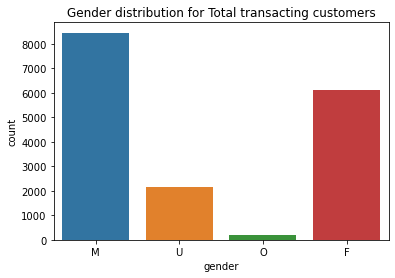

In [39]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for Total transacting customers');

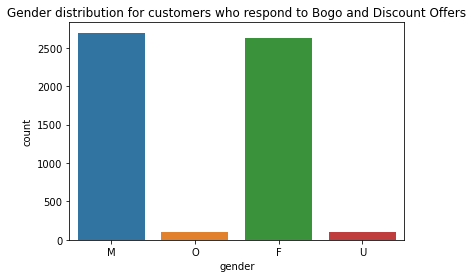

In [40]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income']][final_offer['int_offer']=='All']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers who respond to Bogo and Discount Offers');

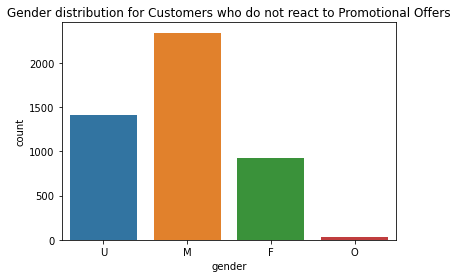

In [41]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income']][final_offer['int_offer']=='None']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for Customers who do not react to Promotional Offers');

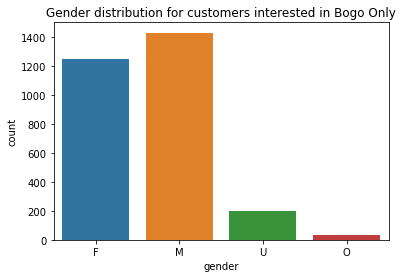

In [42]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income']][final_offer['int_offer']=='Bogo_only']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers interested in Bogo Only');

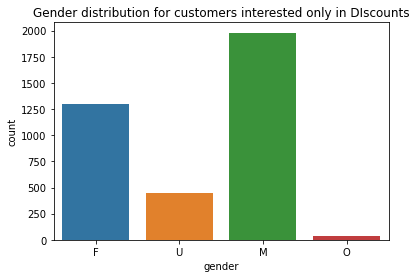

In [43]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income']][final_offer['int_offer']=='Disc_only']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers interested only in DIscounts');

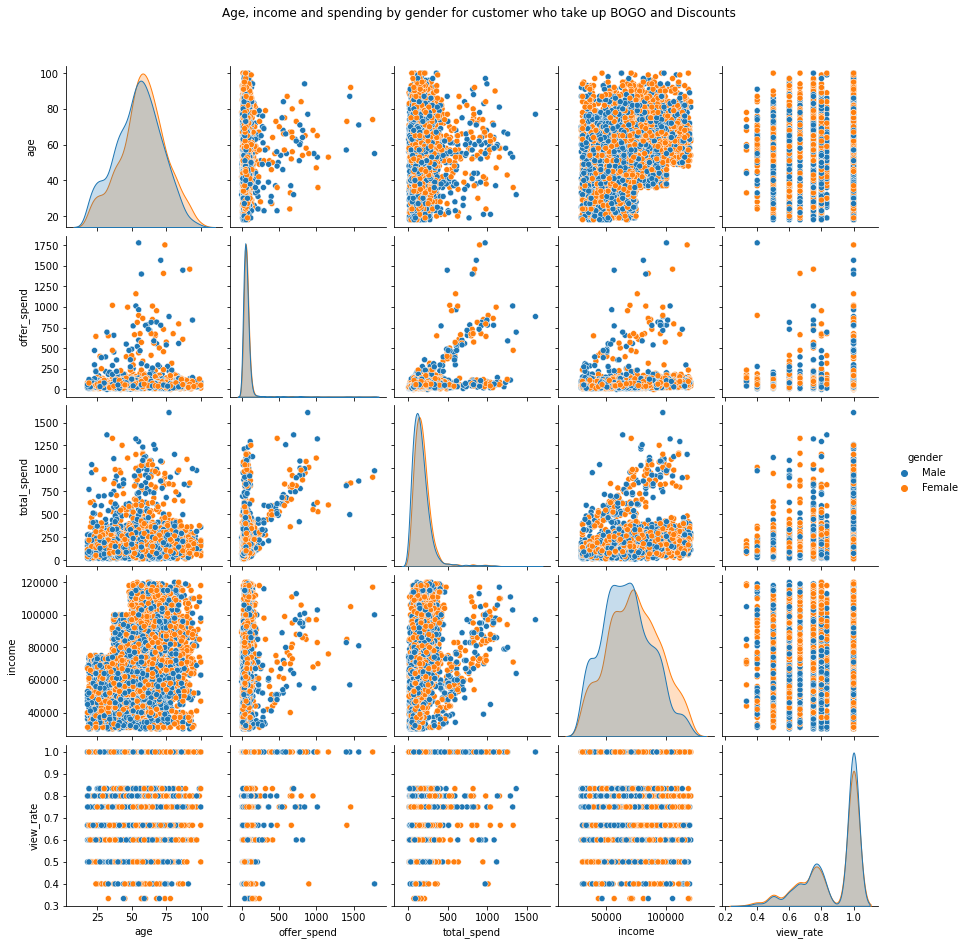

In [44]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income','view_rate']][final_offer['int_offer']=='All'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for customer who take up BOGO and Discounts", y=1.05);

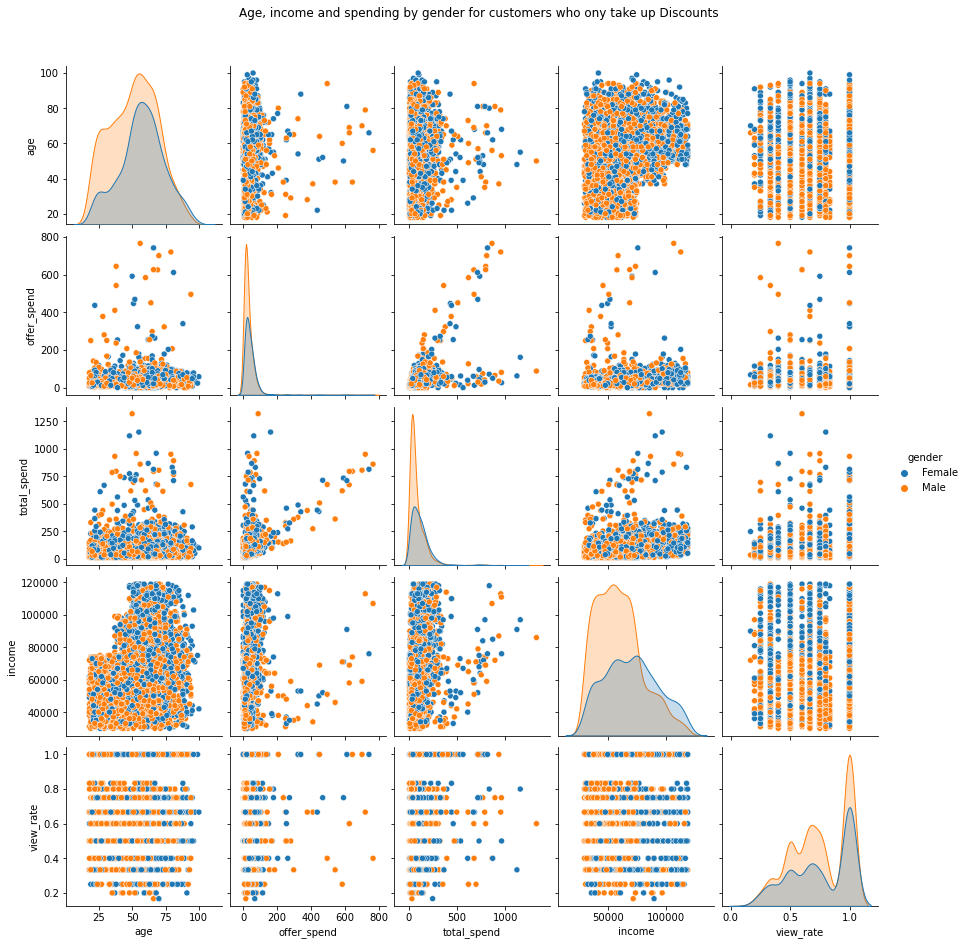

In [45]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income','view_rate']][final_offer['int_offer']=='Disc_only'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for customers who ony take up Discounts", y=1.05);

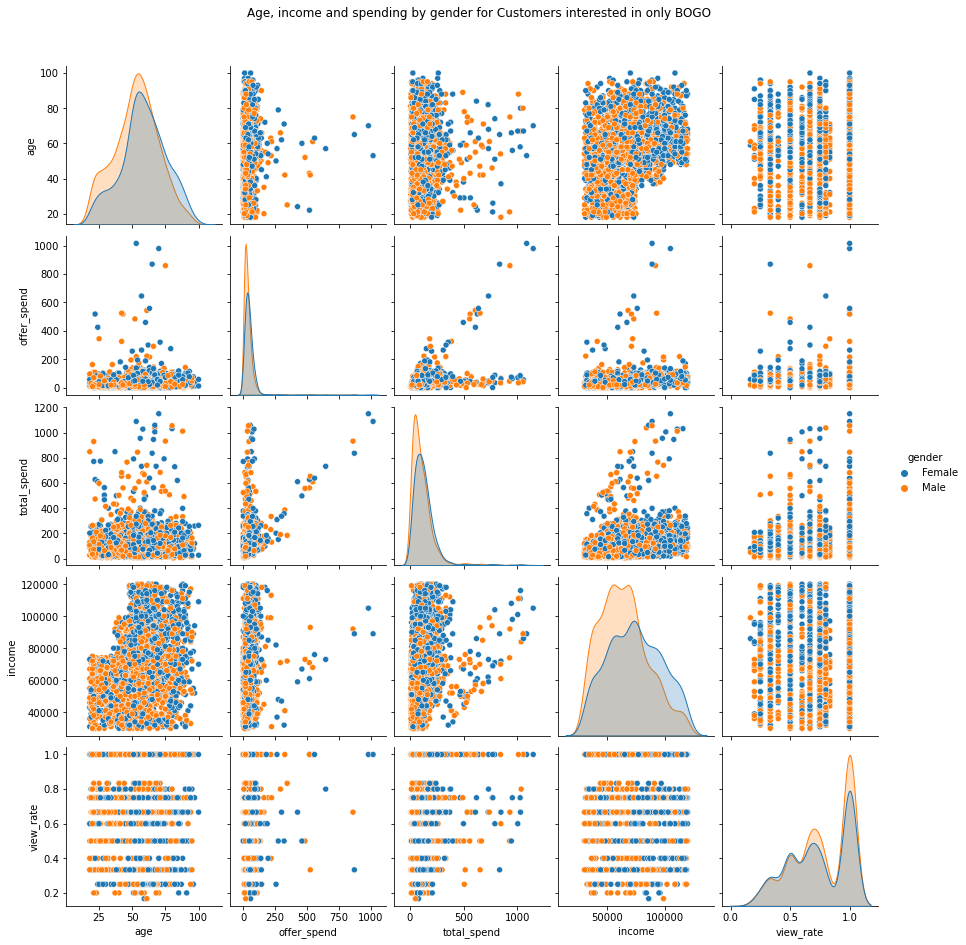

In [46]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income','view_rate']][final_offer['int_offer']=='Bogo_only'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for Customers interested in only BOGO", y=1.05);

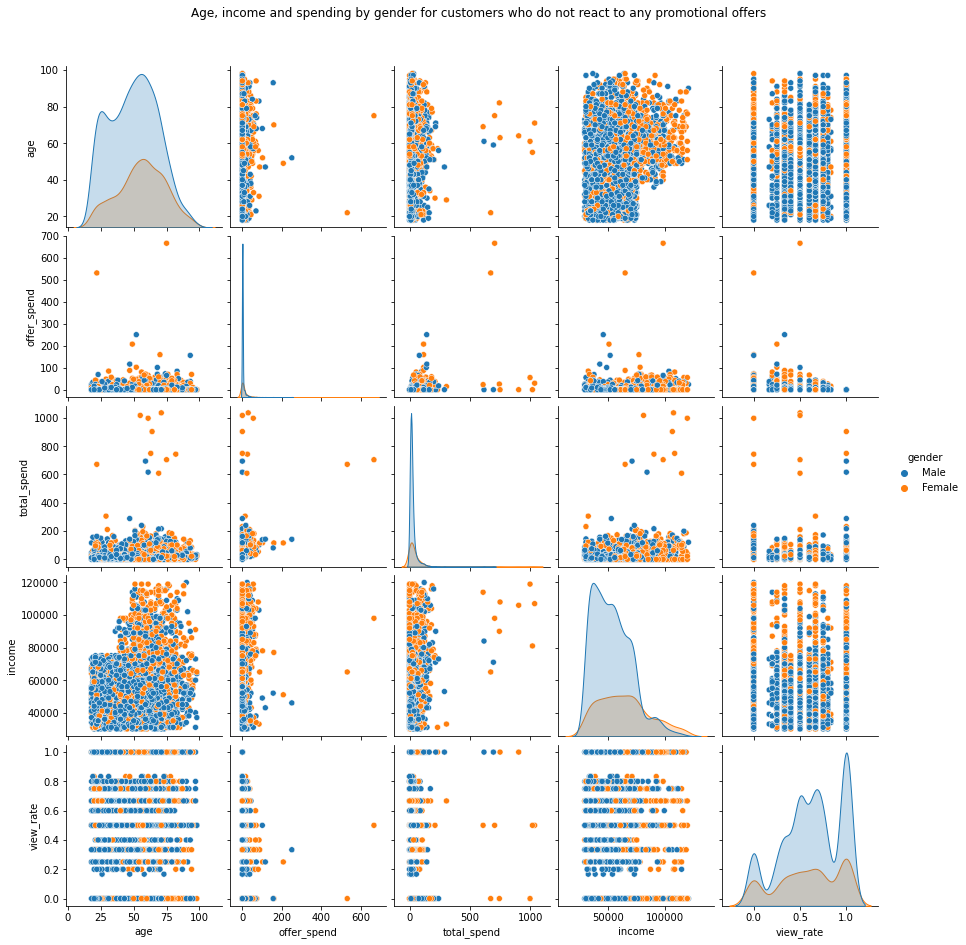

In [47]:
df = final_offer[['gender', 'age', 'offer_spend', 'total_spend', 'income','view_rate']][final_offer['int_offer']=='None'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for customers who do not react to any promotional offers", y=1.05);

<AxesSubplot:>

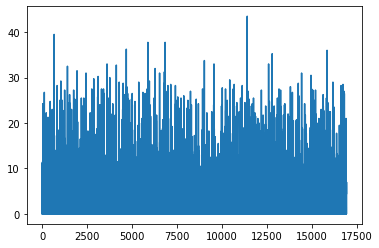

In [48]:
final_offer['offer_time'].plot()

<AxesSubplot:>

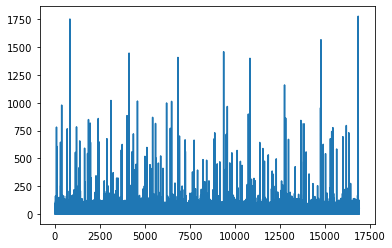

In [49]:
final_offer['offer_spend'].plot()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


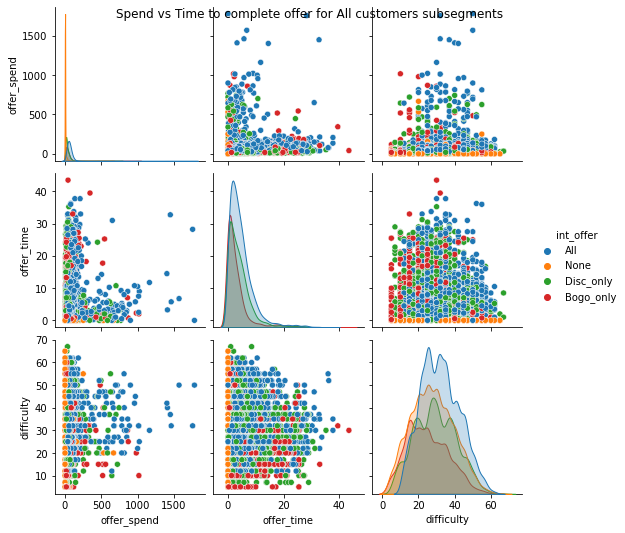

In [50]:
x=final_offer[['offer_spend','offer_time','int_offer','difficulty']]
ax=sns.pairplot(x, hue='int_offer')
ax.fig.suptitle('Spend vs Time to complete offer for All customers subsegments');

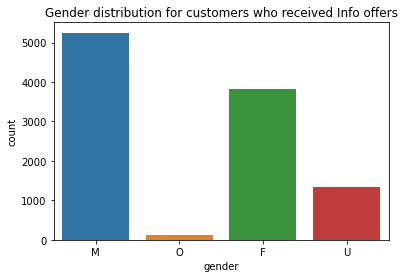

In [51]:
df = final_info[['gender', 'age', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers who received Info offers');

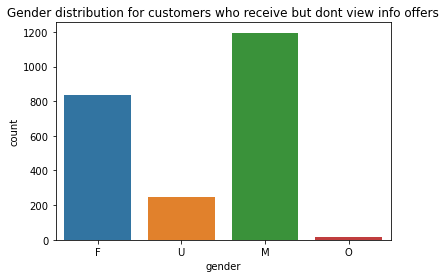

In [52]:
df = final_info[['gender', 'age', 'income']][final_info['info_resp']=='None']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers who receive but dont view info offers');

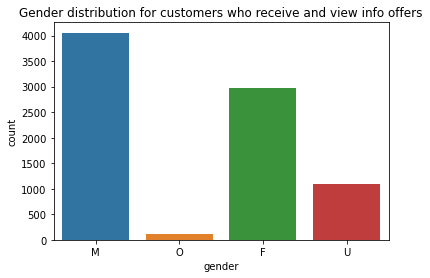

In [53]:
df = final_info[['gender', 'age', 'income']][final_info['info_resp']!='None']

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution for customers who receive and view info offers');

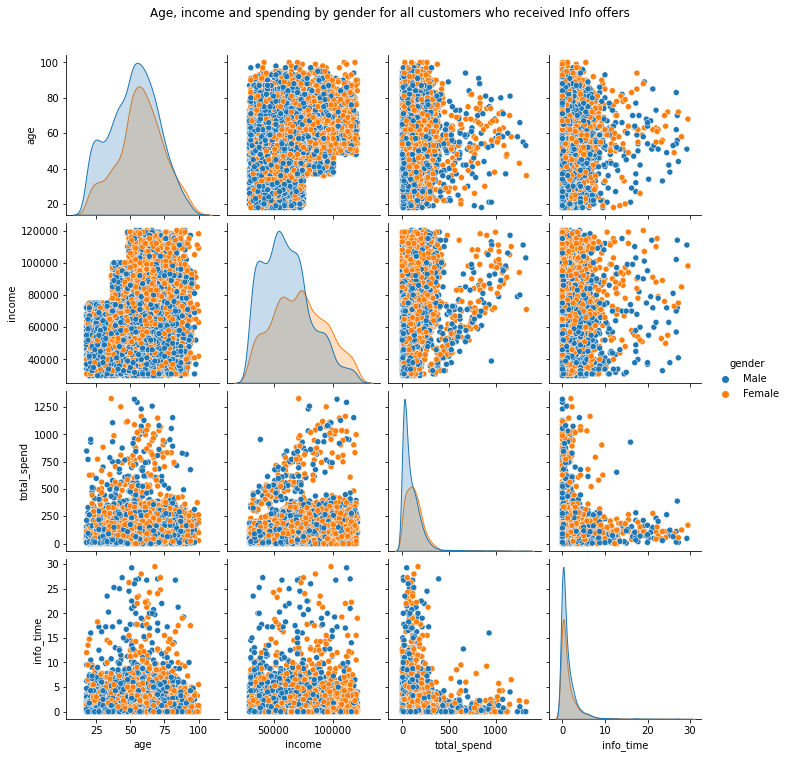

In [54]:
df = final_info[['gender', 'age', 'income','total_spend','info_time']].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for all customers who received Info offers", y=1.05);

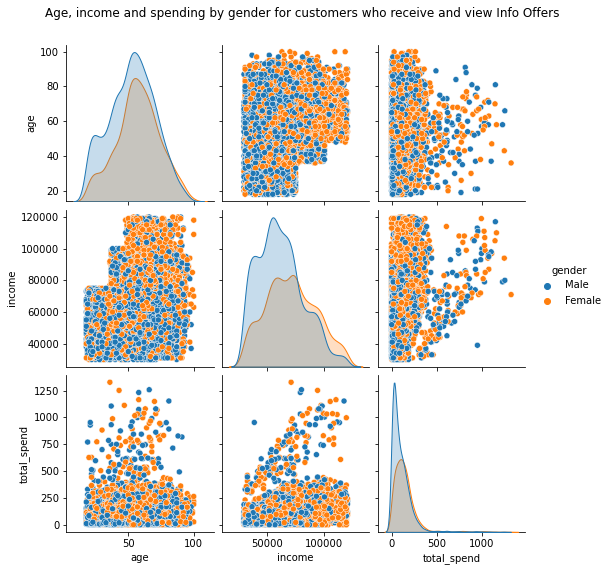

In [55]:
df = final_info[['gender', 'age', 'income','total_spend']][final_info['info_resp']!='None'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender for customers who receive and view Info Offers", y=1.05);

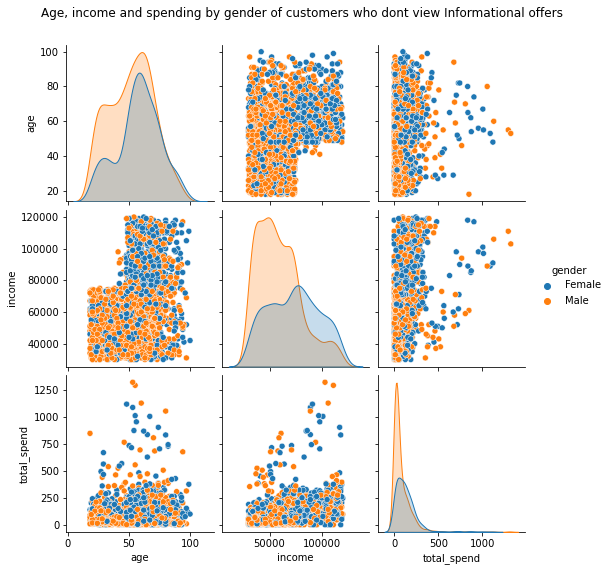

In [56]:
df = final_info[['gender', 'age', 'income','total_spend']][final_info['info_resp']=='None'].query('gender in ["F", "M"]')
df['gender'] = df['gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending by gender of customers who dont view Informational offers", y=1.05);

# Modelling

In [57]:
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  
import scipy

## Model Building: Promotional Offers

In [58]:
labels= final_offer['int_offer'].unique()
i=0
idx2class ={}
class2idx ={}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i+=1
print(idx2class)
print("--------------------------------------------------------")
print(class2idx)

{0: 'All', 1: 'None', 2: 'Disc_only', 3: 'Bogo_only'}
--------------------------------------------------------
{'All': 0, 'None': 1, 'Disc_only': 2, 'Bogo_only': 3}


In [59]:
df1=final_offer[['id',  'bogo', 'discount',  'difficulty','view_rate', 'reward',
       'total_spend',  'age', 'income', 'yr_w_starbucks', 'email',
       'social', 'mobile','web',
       'gender_F', 'gender_M', 'gender_O', 'gender_U', 'year_joined_2013',
       'year_joined_2014', 'year_joined_2015', 'year_joined_2016',
       'year_joined_2017', 'year_joined_2018']]
df1['y']=final_offer['int_offer'].map(class2idx)
#df_xgb['y'].value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
df1.head()

,id,bogo,discount,difficulty,view_rate,reward,total_spend,age,income,yr_w_starbucks,...,gender_M,gender_O,gender_U,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,y
0,0009655768c64bdeb2e877511632db8f,1,2,25,0.666667,9,127.60,33.0000,72000.000000,4,...,1,0,0,0,0,0,0,1,0,0
1,00116118485d4dfda04fdbaba9a87b5c,1,0,5,1.000000,5,4.09,54.3778,65404.991568,2,...,0,0,1,0,0,0,0,0,1,1
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,32,1.000000,13,79.46,40.0000,57000.000000,3,...,0,1,0,0,0,0,0,0,1,0
3,0020c2b971eb4e9188eac86d93036a77,2,1,30,0.500000,22,196.86,59.0000,90000.000000,5,...,0,0,0,0,0,0,1,0,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,17,1.000000,13,154.05,24.0000,60000.000000,4,...,0,0,0,0,0,0,1,0,0,0


In [61]:
X_df1=df1.drop(['id','y'], axis=1)
scaler=MinMaxScaler()
X_df1=scaler.fit_transform(X_df1)
y_df1=df1['y']

#splitting for building
X_train, X_test, y_train, y_test = train_test_split(X_df1,y_df1,\
                                                        stratify=y_df1, test_size=0.20, random_state=1234)
#making up for the imbalance in the data set
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Building a naive predictor using Logistic regression

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))

confusion matrix
[[772  38 166 130]
 [ 32 675 112 126]
 [111 150 446  45]
 [ 51  93  36 403]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1106
           1       0.71      0.71      0.71       945
           2       0.59      0.59      0.59       752
           3       0.57      0.69      0.63       583

    accuracy                           0.68      3386
   macro avg       0.67      0.67      0.67      3386
weighted avg       0.69      0.68      0.68      3386

Accuracy : 0.678086


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [63]:
classifiers = [GaussianNB(),
               KNeighborsClassifier(4),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               CatBoostClassifier(verbose=False)
]

In [64]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print('\n Classfier:')
    print(classifier)
    print("\n model score: %.3f" % classifier.score(X_test, y_test))
    print('confusion matrix')
    print(metrics.confusion_matrix(y_test, y_pred))
    print('classification report')
    print(metrics.classification_report(y_test, y_pred))
    print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
    #print('f1 score : %f' % (metrics.fbeta_score(y_test, y_pred, beta=0.5)))


 Classfier:
GaussianNB()

 model score: 0.600
confusion matrix
[[708  99 105 194]
 [ 62 722  80  81]
 [151 252 302  47]
 [101 127  54 301]]
classification report
              precision    recall  f1-score   support

           0       0.69      0.64      0.67      1106
           1       0.60      0.76      0.67       945
           2       0.56      0.40      0.47       752
           3       0.48      0.52      0.50       583

    accuracy                           0.60      3386
   macro avg       0.58      0.58      0.58      3386
weighted avg       0.60      0.60      0.59      3386

Accuracy : 0.600413

 Classfier:
KNeighborsClassifier(n_neighbors=4)

 model score: 0.607
confusion matrix
[[805  75 143  83]
 [ 92 575 141 137]
 [169 178 359  46]
 [ 96 127  44 316]]
classification report
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1106
           1       0.60      0.61      0.61       945
           2       0.52      0.48

The naiveBayes which is my second benchmark Model has an accuracy of 59.8%. this is what my final model is bench marked against

In [87]:
#Best performing model is Catboost. Applying Random search CV to improve its performanc
model1 = CatBoostClassifier()
parameters = {'depth'       : range(5, 12),
            'learning_rate' : np.arange(0.08,0.11,0.01),
            'iterations'    : [500, 1000, 1500],
            'l2_leaf_reg' : [2,3,4,5],
                 }

In [ ]:
CB_search=RandomizedSearchCV(estimator=model1, param_distributions = parameters, 
                               cv = 3, n_iter = 5, n_jobs=-1)
CB_search.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [90]:
print("\n The best estimator across ALL searched params:\n",
          CB_search.best_estimator_)
print("\n The best score across ALL searched params:\n",
          CB_search.best_score_)
print("\n The best parameters across ALL searched params:\n",
          CB_search.best_params_)


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.80436587189124

 The best parameters across ALL searched params:
 {'learning_rate': 0.09, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 11}


In [65]:
RandS_model=CatBoostClassifier(learning_rate= 0.09, l2_leaf_reg= 5, iterations= 1500, depth= 11, verbose=True)
RandS_model.fit(X_train, y_train)
y_pred = RandS_model.predict(X_test)


0:	learn: 1.2732825	total: 245ms	remaining: 6m 7s
1:	learn: 1.1829270	total: 462ms	remaining: 5m 46s
2:	learn: 1.1106117	total: 682ms	remaining: 5m 40s
3:	learn: 1.0584382	total: 904ms	remaining: 5m 37s
4:	learn: 1.0080549	total: 1.12s	remaining: 5m 35s
5:	learn: 0.9650272	total: 1.34s	remaining: 5m 34s
6:	learn: 0.9313579	total: 1.56s	remaining: 5m 33s
7:	learn: 0.9001481	total: 1.78s	remaining: 5m 32s
8:	learn: 0.8702240	total: 2s	remaining: 5m 32s
9:	learn: 0.8440732	total: 2.22s	remaining: 5m 31s
10:	learn: 0.8194499	total: 2.44s	remaining: 5m 30s
11:	learn: 0.7984627	total: 2.66s	remaining: 5m 30s
12:	learn: 0.7789329	total: 2.88s	remaining: 5m 30s
13:	learn: 0.7600008	total: 3.1s	remaining: 5m 29s
14:	learn: 0.7446841	total: 3.33s	remaining: 5m 29s
15:	learn: 0.7299959	total: 3.54s	remaining: 5m 28s
16:	learn: 0.7167424	total: 3.76s	remaining: 5m 28s
17:	learn: 0.7046907	total: 3.98s	remaining: 5m 28s
18:	learn: 0.6920965	total: 4.2s	remaining: 5m 27s
19:	learn: 0.6812141	total: 

159:	learn: 0.3949241	total: 35.5s	remaining: 4m 57s
160:	learn: 0.3938278	total: 35.8s	remaining: 4m 57s
161:	learn: 0.3926921	total: 36s	remaining: 4m 57s
162:	learn: 0.3919209	total: 36.2s	remaining: 4m 57s
163:	learn: 0.3903767	total: 36.4s	remaining: 4m 56s
164:	learn: 0.3897738	total: 36.7s	remaining: 4m 56s
165:	learn: 0.3883503	total: 36.9s	remaining: 4m 56s
166:	learn: 0.3877631	total: 37.1s	remaining: 4m 56s
167:	learn: 0.3870940	total: 37.3s	remaining: 4m 55s
168:	learn: 0.3864474	total: 37.5s	remaining: 4m 55s
169:	learn: 0.3856831	total: 37.8s	remaining: 4m 55s
170:	learn: 0.3849504	total: 38s	remaining: 4m 55s
171:	learn: 0.3843245	total: 38.2s	remaining: 4m 55s
172:	learn: 0.3837138	total: 38.5s	remaining: 4m 54s
173:	learn: 0.3831964	total: 38.7s	remaining: 4m 54s
174:	learn: 0.3823728	total: 38.9s	remaining: 4m 54s
175:	learn: 0.3810286	total: 39.1s	remaining: 4m 54s
176:	learn: 0.3800025	total: 39.3s	remaining: 4m 54s
177:	learn: 0.3786858	total: 39.6s	remaining: 4m 5

315:	learn: 0.2821540	total: 1m 10s	remaining: 4m 23s
316:	learn: 0.2817970	total: 1m 10s	remaining: 4m 23s
317:	learn: 0.2811630	total: 1m 10s	remaining: 4m 23s
318:	learn: 0.2808379	total: 1m 11s	remaining: 4m 22s
319:	learn: 0.2801897	total: 1m 11s	remaining: 4m 22s
320:	learn: 0.2794216	total: 1m 11s	remaining: 4m 22s
321:	learn: 0.2789691	total: 1m 11s	remaining: 4m 22s
322:	learn: 0.2785260	total: 1m 11s	remaining: 4m 22s
323:	learn: 0.2781346	total: 1m 12s	remaining: 4m 21s
324:	learn: 0.2776029	total: 1m 12s	remaining: 4m 21s
325:	learn: 0.2771285	total: 1m 12s	remaining: 4m 21s
326:	learn: 0.2763838	total: 1m 12s	remaining: 4m 21s
327:	learn: 0.2755712	total: 1m 13s	remaining: 4m 20s
328:	learn: 0.2750591	total: 1m 13s	remaining: 4m 20s
329:	learn: 0.2746085	total: 1m 13s	remaining: 4m 20s
330:	learn: 0.2740361	total: 1m 13s	remaining: 4m 20s
331:	learn: 0.2735937	total: 1m 13s	remaining: 4m 19s
332:	learn: 0.2733488	total: 1m 14s	remaining: 4m 19s
333:	learn: 0.2730142	total:

468:	learn: 0.2138257	total: 1m 45s	remaining: 3m 52s
469:	learn: 0.2134149	total: 1m 45s	remaining: 3m 52s
470:	learn: 0.2130538	total: 1m 46s	remaining: 3m 51s
471:	learn: 0.2126922	total: 1m 46s	remaining: 3m 51s
472:	learn: 0.2124840	total: 1m 46s	remaining: 3m 51s
473:	learn: 0.2121386	total: 1m 46s	remaining: 3m 51s
474:	learn: 0.2117556	total: 1m 47s	remaining: 3m 51s
475:	learn: 0.2113460	total: 1m 47s	remaining: 3m 50s
476:	learn: 0.2109716	total: 1m 47s	remaining: 3m 50s
477:	learn: 0.2107239	total: 1m 47s	remaining: 3m 50s
478:	learn: 0.2104330	total: 1m 47s	remaining: 3m 50s
479:	learn: 0.2099523	total: 1m 48s	remaining: 3m 49s
480:	learn: 0.2095866	total: 1m 48s	remaining: 3m 49s
481:	learn: 0.2092974	total: 1m 48s	remaining: 3m 49s
482:	learn: 0.2088509	total: 1m 48s	remaining: 3m 49s
483:	learn: 0.2085682	total: 1m 49s	remaining: 3m 48s
484:	learn: 0.2083422	total: 1m 49s	remaining: 3m 48s
485:	learn: 0.2079951	total: 1m 49s	remaining: 3m 48s
486:	learn: 0.2076126	total:

621:	learn: 0.1675275	total: 2m 19s	remaining: 3m 17s
622:	learn: 0.1672599	total: 2m 20s	remaining: 3m 17s
623:	learn: 0.1670468	total: 2m 20s	remaining: 3m 16s
624:	learn: 0.1667953	total: 2m 20s	remaining: 3m 16s
625:	learn: 0.1667092	total: 2m 20s	remaining: 3m 16s
626:	learn: 0.1664951	total: 2m 20s	remaining: 3m 16s
627:	learn: 0.1662236	total: 2m 21s	remaining: 3m 16s
628:	learn: 0.1659462	total: 2m 21s	remaining: 3m 15s
629:	learn: 0.1656865	total: 2m 21s	remaining: 3m 15s
630:	learn: 0.1655013	total: 2m 21s	remaining: 3m 15s
631:	learn: 0.1652459	total: 2m 22s	remaining: 3m 15s
632:	learn: 0.1649676	total: 2m 22s	remaining: 3m 14s
633:	learn: 0.1647292	total: 2m 22s	remaining: 3m 14s
634:	learn: 0.1645098	total: 2m 22s	remaining: 3m 14s
635:	learn: 0.1642530	total: 2m 22s	remaining: 3m 14s
636:	learn: 0.1639872	total: 2m 23s	remaining: 3m 13s
637:	learn: 0.1637811	total: 2m 23s	remaining: 3m 13s
638:	learn: 0.1636017	total: 2m 23s	remaining: 3m 13s
639:	learn: 0.1633312	total:

774:	learn: 0.1357267	total: 2m 53s	remaining: 2m 42s
775:	learn: 0.1355576	total: 2m 54s	remaining: 2m 42s
776:	learn: 0.1353922	total: 2m 54s	remaining: 2m 42s
777:	learn: 0.1351758	total: 2m 54s	remaining: 2m 41s
778:	learn: 0.1349515	total: 2m 54s	remaining: 2m 41s
779:	learn: 0.1346866	total: 2m 54s	remaining: 2m 41s
780:	learn: 0.1344928	total: 2m 55s	remaining: 2m 41s
781:	learn: 0.1343240	total: 2m 55s	remaining: 2m 41s
782:	learn: 0.1340455	total: 2m 55s	remaining: 2m 40s
783:	learn: 0.1338364	total: 2m 55s	remaining: 2m 40s
784:	learn: 0.1336836	total: 2m 56s	remaining: 2m 40s
785:	learn: 0.1335440	total: 2m 56s	remaining: 2m 40s
786:	learn: 0.1333485	total: 2m 56s	remaining: 2m 39s
787:	learn: 0.1331482	total: 2m 56s	remaining: 2m 39s
788:	learn: 0.1329846	total: 2m 56s	remaining: 2m 39s
789:	learn: 0.1328001	total: 2m 57s	remaining: 2m 39s
790:	learn: 0.1326298	total: 2m 57s	remaining: 2m 38s
791:	learn: 0.1325091	total: 2m 57s	remaining: 2m 38s
792:	learn: 0.1323217	total:

927:	learn: 0.1124077	total: 3m 27s	remaining: 2m 8s
928:	learn: 0.1122976	total: 3m 27s	remaining: 2m 7s
929:	learn: 0.1122224	total: 3m 28s	remaining: 2m 7s
930:	learn: 0.1121184	total: 3m 28s	remaining: 2m 7s
931:	learn: 0.1120110	total: 3m 28s	remaining: 2m 7s
932:	learn: 0.1118388	total: 3m 28s	remaining: 2m 6s
933:	learn: 0.1117429	total: 3m 29s	remaining: 2m 6s
934:	learn: 0.1116034	total: 3m 29s	remaining: 2m 6s
935:	learn: 0.1115048	total: 3m 29s	remaining: 2m 6s
936:	learn: 0.1113650	total: 3m 29s	remaining: 2m 6s
937:	learn: 0.1112493	total: 3m 29s	remaining: 2m 5s
938:	learn: 0.1111832	total: 3m 30s	remaining: 2m 5s
939:	learn: 0.1110221	total: 3m 30s	remaining: 2m 5s
940:	learn: 0.1108653	total: 3m 30s	remaining: 2m 5s
941:	learn: 0.1106832	total: 3m 30s	remaining: 2m 4s
942:	learn: 0.1106022	total: 3m 31s	remaining: 2m 4s
943:	learn: 0.1104683	total: 3m 31s	remaining: 2m 4s
944:	learn: 0.1103444	total: 3m 31s	remaining: 2m 4s
945:	learn: 0.1102321	total: 3m 31s	remaining:

1079:	learn: 0.0958811	total: 4m 1s	remaining: 1m 33s
1080:	learn: 0.0957693	total: 4m 1s	remaining: 1m 33s
1081:	learn: 0.0956355	total: 4m 2s	remaining: 1m 33s
1082:	learn: 0.0955077	total: 4m 2s	remaining: 1m 33s
1083:	learn: 0.0953707	total: 4m 2s	remaining: 1m 33s
1084:	learn: 0.0952352	total: 4m 2s	remaining: 1m 32s
1085:	learn: 0.0951622	total: 4m 2s	remaining: 1m 32s
1086:	learn: 0.0950600	total: 4m 3s	remaining: 1m 32s
1087:	learn: 0.0949329	total: 4m 3s	remaining: 1m 32s
1088:	learn: 0.0948319	total: 4m 3s	remaining: 1m 31s
1089:	learn: 0.0947639	total: 4m 3s	remaining: 1m 31s
1090:	learn: 0.0946276	total: 4m 4s	remaining: 1m 31s
1091:	learn: 0.0944932	total: 4m 4s	remaining: 1m 31s
1092:	learn: 0.0943888	total: 4m 4s	remaining: 1m 31s
1093:	learn: 0.0942597	total: 4m 4s	remaining: 1m 30s
1094:	learn: 0.0941872	total: 4m 4s	remaining: 1m 30s
1095:	learn: 0.0941240	total: 4m 5s	remaining: 1m 30s
1096:	learn: 0.0940269	total: 4m 5s	remaining: 1m 30s
1097:	learn: 0.0939339	total

1230:	learn: 0.0825243	total: 4m 36s	remaining: 1m
1231:	learn: 0.0824610	total: 4m 36s	remaining: 1m
1232:	learn: 0.0823992	total: 4m 36s	remaining: 60s
1233:	learn: 0.0823054	total: 4m 37s	remaining: 59.7s
1234:	learn: 0.0822439	total: 4m 37s	remaining: 59.5s
1235:	learn: 0.0821804	total: 4m 37s	remaining: 59.3s
1236:	learn: 0.0820805	total: 4m 37s	remaining: 59.1s
1237:	learn: 0.0819678	total: 4m 38s	remaining: 58.8s
1238:	learn: 0.0819254	total: 4m 38s	remaining: 58.6s
1239:	learn: 0.0818740	total: 4m 38s	remaining: 58.4s
1240:	learn: 0.0818014	total: 4m 38s	remaining: 58.2s
1241:	learn: 0.0817194	total: 4m 38s	remaining: 57.9s
1242:	learn: 0.0816601	total: 4m 39s	remaining: 57.7s
1243:	learn: 0.0815798	total: 4m 39s	remaining: 57.5s
1244:	learn: 0.0814862	total: 4m 39s	remaining: 57.3s
1245:	learn: 0.0814204	total: 4m 39s	remaining: 57s
1246:	learn: 0.0813622	total: 4m 40s	remaining: 56.8s
1247:	learn: 0.0813040	total: 4m 40s	remaining: 56.6s
1248:	learn: 0.0811792	total: 4m 40s	r

1384:	learn: 0.0724363	total: 5m 10s	remaining: 25.8s
1385:	learn: 0.0723564	total: 5m 11s	remaining: 25.6s
1386:	learn: 0.0722905	total: 5m 11s	remaining: 25.4s
1387:	learn: 0.0722252	total: 5m 11s	remaining: 25.1s
1388:	learn: 0.0721565	total: 5m 11s	remaining: 24.9s
1389:	learn: 0.0720923	total: 5m 12s	remaining: 24.7s
1390:	learn: 0.0720266	total: 5m 12s	remaining: 24.5s
1391:	learn: 0.0719996	total: 5m 12s	remaining: 24.2s
1392:	learn: 0.0719338	total: 5m 12s	remaining: 24s
1393:	learn: 0.0718758	total: 5m 12s	remaining: 23.8s
1394:	learn: 0.0718152	total: 5m 13s	remaining: 23.6s
1395:	learn: 0.0717694	total: 5m 13s	remaining: 23.3s
1396:	learn: 0.0717280	total: 5m 13s	remaining: 23.1s
1397:	learn: 0.0716410	total: 5m 13s	remaining: 22.9s
1398:	learn: 0.0715917	total: 5m 14s	remaining: 22.7s
1399:	learn: 0.0715386	total: 5m 14s	remaining: 22.4s
1400:	learn: 0.0714676	total: 5m 14s	remaining: 22.2s
1401:	learn: 0.0713913	total: 5m 14s	remaining: 22s
1402:	learn: 0.0713550	total: 5m

In [66]:
print(RandS_model)
print("\n model score: %.3f" % RandS_model.score(X_test, y_test))
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))


 model score: 0.758
confusion matrix
[[931  18 110  47]
 [ 15 754 102  74]
 [128  95 494  35]
 [ 76  77  43 387]]
classification report
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1106
           1       0.80      0.80      0.80       945
           2       0.66      0.66      0.66       752
           3       0.71      0.66      0.69       583

    accuracy                           0.76      3386
   macro avg       0.75      0.74      0.74      3386
weighted avg       0.76      0.76      0.76      3386

Accuracy : 0.757826


the performance does not improve based off the Random search parameters. Trying a K-fold cross-val model:

In [67]:
X=pd.DataFrame(X_train)
y=y_train
tes=pd.DataFrame(X_test)
tes_y=y_test

In [68]:
testsplit_store=[]
test_store=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, f1_score, log_loss
from catboost import CatBoostRegressor, CatBoostClassifier
fold=StratifiedKFold(n_splits=5,random_state=22,shuffle=True)
 
# cat_yhat = list()l
i=1
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = CatBoostClassifier(learning_rate=0.1,n_estimators=1000,
                        use_best_model=True, eval_metric='Accuracy')
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    predict = cat.predict(X_test)
    print("err: ", metrics.accuracy_score(predict, y_test))
    testsplit_store.append(metrics.accuracy_score(y_test,predict))
    pred = cat.predict(tes)
    test_store.append(pred)
np.mean(testsplit_store)

0:	learn: 0.6826787	test: 0.6826787	test1: 0.7146893	best: 0.7146893 (0)	total: 15.9ms	remaining: 15.9s
100:	learn: 0.7822125	test: 0.7822125	test1: 0.7774011	best: 0.7774011 (97)	total: 1.54s	remaining: 13.7s
200:	learn: 0.8106103	test: 0.8106103	test1: 0.7901130	best: 0.7915254 (197)	total: 3.04s	remaining: 12.1s
300:	learn: 0.8303899	test: 0.8303899	test1: 0.7974576	best: 0.7974576 (300)	total: 4.55s	remaining: 10.6s
400:	learn: 0.8452953	test: 0.8452953	test1: 0.7994350	best: 0.7997175 (394)	total: 6.07s	remaining: 9.06s
500:	learn: 0.8593529	test: 0.8593529	test1: 0.7971751	best: 0.8000000 (411)	total: 7.57s	remaining: 7.54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8
bestIteration = 411

Shrink model to first 412 iterations.
err:  0.8
0:	learn: 0.7145582	test: 0.7145582	test1: 0.7055665	best: 0.7055665 (0)	total: 15ms	remaining: 15s
100:	learn: 0.7856891	test: 0.7856891	test1: 0.7764905	best: 0.7764905 (100)	total: 1.52s	remaining: 13.5s
200:	learn: 0.8

0.7979203164735801

In [69]:
print("Confusion Matrix:")
print(metrics.classification_report(tes_y, scipy.stats.mode(test_store, 0)[0].reshape(scipy.stats.mode(test_store, 0)[0].shape[1],1)))
print('accuracy: ')
print(metrics.accuracy_score(tes_y, scipy.stats.mode(test_store, 0)[0].reshape(scipy.stats.mode(test_store, 0)[0].shape[1],1)))

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1106
           1       0.80      0.81      0.80       945
           2       0.68      0.67      0.67       752
           3       0.69      0.66      0.67       583

    accuracy                           0.76      3386
   macro avg       0.75      0.75      0.75      3386
weighted avg       0.76      0.76      0.76      3386

accuracy: 
0.7649143532191376


using the initial Catboost Model

In [70]:
final_model = CatBoostClassifier(verbose=False)
# Grid Search on the CatBoost Model
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('\n Classfier:')
print(final_model)
print("\n model score: %.3f" % final_model.score(X_test, y_test))
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))



 Classfier:

 model score: 0.792
confusion matrix
[[737  11  84  53]
 [  5 708  95  77]
 [118  61 659  47]
 [ 58  71  56 699]]
classification report
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       885
           1       0.83      0.80      0.82       885
           2       0.74      0.74      0.74       885
           3       0.80      0.79      0.79       884

    accuracy                           0.79      3539
   macro avg       0.79      0.79      0.79      3539
weighted avg       0.79      0.79      0.79      3539

Accuracy : 0.792032


In [71]:
pd.DataFrame({'feature_importance': final_model.get_feature_importance(), 
              'feature_names': df1.drop(['id','y'], axis=1).columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
5,23.470143,total_spend
1,11.586008,discount
3,11.028751,view_rate
0,9.072898,bogo
7,6.589566,income
4,5.915612,reward
6,5.596864,age
2,5.227833,difficulty
10,4.658572,social
8,3.902046,yr_w_starbucks


### Modelling: Informational Offers

In [72]:
labels= final_info['info_resp'].unique()
i=0
idx2class ={}
class2idx ={}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i+=1
print(idx2class)
print("--------------------------------------------------------")
print(class2idx)

{0: 'Info', 1: 'None'}
--------------------------------------------------------
{'Info': 0, 'None': 1}


In [88]:
df2=final_info[['id','total_spend', 'age', 'income', 'yr_w_starbucks','email', 'social', 'mobile',
       'web', 'gender_F', 'gender_M', 'gender_O', 'gender_U', 'year_joined_2013',
       'year_joined_2014', 'year_joined_2015', 'year_joined_2016',
       'year_joined_2017', 'year_joined_2018']]
df2['y']=final_info['info_resp'].map(class2idx)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [89]:
X_df2=df2.drop(['id','y'], axis=1)
scaler=MinMaxScaler()
X_df2=scaler.fit_transform(X_df2)
y_df2=df2['y']

X_train, X_test, y_train, y_test = train_test_split(X_df2,y_df2,\
                                                        stratify=y_df2, test_size=0.20, random_state=1234)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

#### Naive predictor

Assuming that all customers are interested in the offer

In [90]:
print('Naive predictor accuracy')
print(metrics.accuracy_score(y_train, np.zeros(len(y_train))))
print("confusion Matrix")
print(metrics.confusion_matrix(y_train, np.zeros(len(y_train))))

Naive predictor accuracy
0.5
confusion Matrix
[[6600    0]
 [6600    0]]


In [91]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))

confusion matrix
[[1168  483]
 [ 101  358]]
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1651
           1       0.43      0.78      0.55       459

    accuracy                           0.72      2110
   macro avg       0.67      0.74      0.68      2110
weighted avg       0.81      0.72      0.75      2110

Accuracy : 0.723223


In [92]:
classifier2 = [GaussianNB(),
               KNeighborsClassifier(2),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               CatBoostClassifier(verbose=False)
]

Building the actual models

In [93]:
for classifier in classifier2:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classifier)
    print("\n model score: %.3f" % classifier.score(X_test, y_test))
    print('confusion matrix')
    print(metrics.confusion_matrix(y_test, y_pred))
    print('classification report')
    print(metrics.classification_report(y_test, y_pred))
    print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
    #print('f1 score : %f' % (metrics.fbeta_score(y_test, y_pred, beta=0.5)))

GaussianNB()

 model score: 0.709
confusion matrix
[[1129  522]
 [  93  366]]
classification report
              precision    recall  f1-score   support

           0       0.92      0.68      0.79      1651
           1       0.41      0.80      0.54       459

    accuracy                           0.71      2110
   macro avg       0.67      0.74      0.66      2110
weighted avg       0.81      0.71      0.73      2110

Accuracy : 0.708531
KNeighborsClassifier(n_neighbors=2)

 model score: 0.760
confusion matrix
[[1400  251]
 [ 256  203]]
classification report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1651
           1       0.45      0.44      0.44       459

    accuracy                           0.76      2110
   macro avg       0.65      0.65      0.65      2110
weighted avg       0.76      0.76      0.76      2110

Accuracy : 0.759716
DecisionTreeClassifier()

 model score: 0.709
confusion matrix
[[1250  401]
 [ 213 

In [95]:
info_model=CatBoostClassifier(verbose=False)
info_model.fit(X_train, y_train)
y_pred = info_model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))

[[1393  258]
 [ 180  279]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1651
           1       0.52      0.61      0.56       459

    accuracy                           0.79      2110
   macro avg       0.70      0.73      0.71      2110
weighted avg       0.81      0.79      0.80      2110

Accuracy : 0.792417


In [96]:
pd.DataFrame({'feature_importance': info_model.get_feature_importance(), 
              'feature_names': df2.drop(['id','y'], axis=1).columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
1,38.923098,age
2,21.673168,income
5,16.299932,social
0,7.626740,total_spend
3,5.873881,yr_w_starbucks
7,1.878236,web
11,1.047776,gender_U
9,0.983062,gender_M
8,0.865360,gender_F
6,0.829573,mobile


## Summary

Age, Income and offers sent via social media are the major factors in customers viewing to informational offers while customers' total spends, numbers of discounted offers and offer_view rate help in deciding if cusomers will respond to promotional offers